# MNIST: multilayer perceptrons

Multilayer perceptrons (MLP) have been around for more than 25 years. They are suited to both regression and classification tasks. Here we will use a classic MLP to recognize handwritten digits (MNIST data set), as well as an MLP with a number of more recent twists.

## Data preparation

### Required imports

In [1]:
from tensorflow import keras
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

2024-03-20 10:27:08.290781: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 10:27:08.449770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 10:27:08.449820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 10:27:08.472726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 10:27:08.515347: I tensorflow/core/platform/cpu_feature_guar

### Obtaining the dataset

In Keras' datasets module we have a handle to the MNIST dataset we want to use in this notebook.  Download the training and test set for this data.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Before we can start doing machine learning on the data, some preparations are required.  In this case, the data set is clean, which simplifies this step considerably.  Although it would be better to create a pipeline using the scikit-learn framework, we'll do the preparation by hand in this case.

### Transforming the data

Rather than use the 28 $\times$ 28 images as input directly, we reshape each image to a 784 array.

In [3]:
input_reshaper = FunctionTransformer(lambda x: x.reshape(x.shape[0], -1),
                                     validate=False)

Most training algorithms work better if the input is normalized between 0 and 1.

In [4]:
input_normalizer = FunctionTransformer(lambda x: x.astype(np.float32)/255.0,
                                       validate=True)

Both preprocessing steps can be combined into a single pipeline.

In [5]:
input_pipeline = Pipeline([
    ('reshaper', input_reshaper),
    ('normalizer', input_normalizer),
])

We can now fit and transform the training input, and transform the testing input.

In [6]:
x_train = input_pipeline.fit_transform(x_train)
x_test = input_pipeline.transform(x_test)

The output can be transformed to categorical data, i.e., one category for each digit, rather than a `uint8`. This is a one-hot encoding, so the output is now an array consisting of a single 1.0 value, and nine 0.0 values.  Before calling the `OneHotEncoder`, the output array has to be reshaped.  Note that the type of the output is now `float64`, which we can reduce to `float32` to reduce memory requirements and speed up computations.

In [7]:
output_reshaper = FunctionTransformer(lambda x: x.reshape(-1, 1),
                                      validate=False)

In [12]:
output_encoder = OneHotEncoder(sparse_output=False, categories='auto')

In [9]:
output_type_changer = FunctionTransformer(lambda x: x.astype(np.float32),
                                          validate=False)

In [13]:
output_pipeline = Pipeline([
    ('reshaper', output_reshaper),
    ('binarizer', output_encoder),
    ('type_changer', output_type_changer),
])

Now the training output can be fit and transformed, and the testing output transformed accordingly.

In [14]:
y_train = output_pipeline.fit_transform(y_train)
y_test = output_pipeline.transform(y_test)

In [15]:
y_train.shape

(60000, 10)

In [16]:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Note that the encoding of the output is now a sparse array.

### Validation set

In order to make this reproducible, we have to seed the random number generator.

In [17]:
np.random.seed(1234)

During the training, we will require a validation set, so we split the training data into two sets, one for actual training, the other for validation.  Note, we don't touch the test data set at all during the training process.  The default is using 75 % of the data for training, 25 % for validation. This function will also shuffle the data set prior to splitting (hence seeding the random number generator).

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [19]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((45000, 784), (15000, 784), (45000, 10), (15000, 10))

### Verification

Since we've done quite some transformations, let's verify whether we didn't mess up.

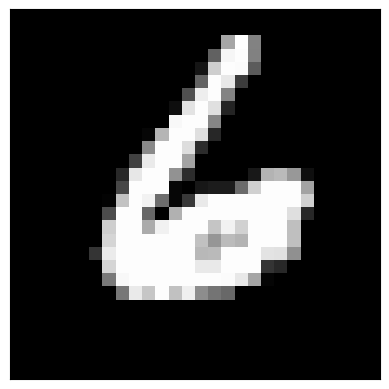

In [20]:
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
plt.imshow(x_train[0].reshape(28, 28), cmap='gray');

In [21]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Everything seems fine, input/output are as expected, and we can start doing some machine learning.

## Classic multilayer perceptron (MLP)

We start off training a classic multilayer neural network to familiarie ourselves with the keras framework.

### Required imports

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import tensorflow as tf

### Model definition

We will create a fully connected neural network with 784 input units (28 $\times$ 28 pixels), two hidden layers with 512 units each, and an output layter with 10 units (ten categories, one per digit). For the two hidden layers, we will use a ReLU activation function, and a SoftMax for the output layer.

To obtain repeatable results, we need to seed the random number generator, taking into account that TensorFlow uses its own.

In [23]:
np.random.seed(1234)
tf.random.set_seed(4958)

In [24]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

2024-03-20 10:46:49.463824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 10:46:49.644538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 10:46:49.644592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 10:46:49.648629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-20 10:46:49.648676: I external/local_xla/xla/stream_executor

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we can can compile the model, specifying the loss function (categorical cross-entropy), the optimizer (SGD, Stochastic Gradient Descent), and the metrics (accuracy) we want to use.

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Training

In [27]:
model_history = model.fit(tf.dtypes.cast(x_train, tf.float32),
                          tf.dtypes.cast(y_train, tf.float32),
                          batch_size=128, epochs=100,
                          verbose=1, validation_data=(tf.dtypes.cast(x_val, tf.float32),
                                                      tf.dtypes.cast(y_val, tf.float32)))

Epoch 1/100


2024-03-20 10:47:27.328449: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ef9d002a860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-20 10:47:27.328497: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-20 10:47:28.038059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1710928048.104877   14165 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 [==============================] - 6s 6ms/step - loss: 1.2804 - accuracy: 0.7204 - val_loss: 0.6708 - val_accuracy: 0.8519
Epoch 2/100
352/352 [==============================] - 2s 6ms/step - loss: 0.5262 - accuracy: 0.8707 - val_loss: 0.4483 - val_accuracy: 0.8785
Epoch 3/100
352/352 [==============================] - 2s 6ms/step - loss: 0.4024 - accuracy: 0.8919 - val_loss: 0.3833 - val_accuracy: 0.8908
Epoch 4/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3525 - accuracy: 0.9019 - val_loss: 0.3425 - val_accuracy: 0.9012
Epoch 5/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3221 - accuracy: 0.9102 - val_loss: 0.3183 - val_accuracy: 0.9062
Epoch 6/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3006 - accuracy: 0.9156 - val_loss: 0.3023 - val_accuracy: 0.9119
Epoch 7/100
352/352 [==============================] - 2s 6ms/step - loss: 0.2837 - accuracy: 0.9204 - val_loss: 0.2876 - val_accuracy: 0.9173
Epoch 8/100

Plot the history of the training process.

In [31]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')

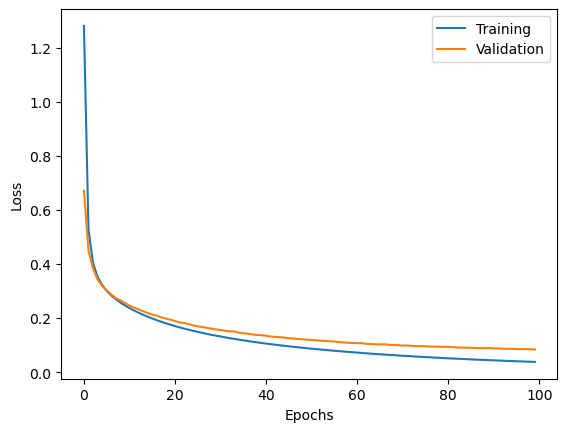

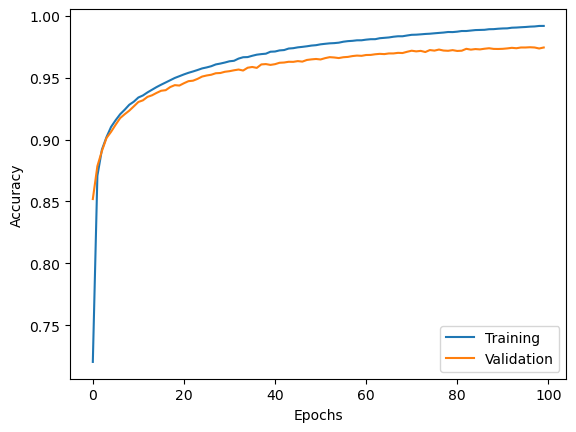

In [32]:
plot_history(model_history)

Let's compare the performance of the model on the training, validation and test set.

In [33]:
model.evaluate(x_train, y_train)

1407/1407 [==============================] - 5s 4ms/step - loss: 0.0365 - accuracy: 0.9925


[0.03650926798582077, 0.9924888610839844]

In [34]:
model.evaluate(x_val, y_val)

469/469 [==============================] - 2s 4ms/step - loss: 0.0839 - accuracy: 0.9743


[0.08386112004518509, 0.9743333458900452]

In [35]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0793 - accuracy: 0.9762


[0.0793130025267601, 0.9761999845504761]

### Save model

We can save the model as an HDF5 file so that it can later be reloaded.

In [36]:
model.save('mnist_mlp.h5')

/home/gjb/mambaforge/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Dropout layers

In order to reduce overfitting, drop out can be applied, i.e., randomly setting input values to 0 during training. We add a drop-out layer between the hidden layers, and between the last hidden layer and the output layer.

In [37]:
np.random.seed(1234)

In [38]:
dropout_model = Sequential()
dropout_model.add(Dense(512, activation='relu', input_shape=(784,)))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(512, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(Dense(10, activation='softmax'))

In [39]:
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
dropout_model.compile(loss='categorical_crossentropy', optimizer=SGD(),
                      metrics=['accuracy'])

In [41]:
dropout_model_history = dropout_model.fit(x_train, y_train, batch_size=128,
                                          epochs=100, verbose=1,
                                          validation_data=(x_val, y_val))

Epoch 1/100
352/352 [==============================] - 3s 7ms/step - loss: 1.3780 - accuracy: 0.6450 - val_loss: 0.6986 - val_accuracy: 0.8360
Epoch 2/100
352/352 [==============================] - 2s 6ms/step - loss: 0.6223 - accuracy: 0.8290 - val_loss: 0.4576 - val_accuracy: 0.8767
Epoch 3/100
352/352 [==============================] - 2s 6ms/step - loss: 0.4785 - accuracy: 0.8627 - val_loss: 0.3853 - val_accuracy: 0.8922
Epoch 4/100
352/352 [==============================] - 2s 6ms/step - loss: 0.4155 - accuracy: 0.8804 - val_loss: 0.3470 - val_accuracy: 0.9007
Epoch 5/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3792 - accuracy: 0.8904 - val_loss: 0.3211 - val_accuracy: 0.9068
Epoch 6/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3527 - accuracy: 0.8985 - val_loss: 0.3038 - val_accuracy: 0.9106
Epoch 7/100
352/352 [==============================] - 2s 6ms/step - loss: 0.3331 - accuracy: 0.9040 - val_loss: 0.2881 - val_accuracy: 0.9163

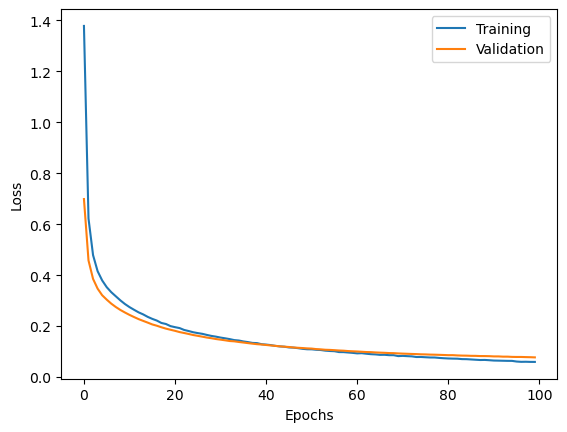

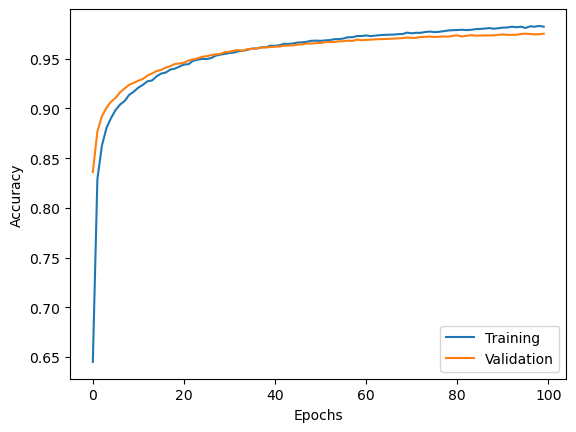

In [42]:
plot_history(dropout_model_history)

Again, let's compare the performance of the model on the training, validation and test set.

In [43]:
dropout_model.evaluate(x_train, y_train)

1407/1407 [==============================] - 5s 4ms/step - loss: 0.0396 - accuracy: 0.9895


[0.03959284722805023, 0.9895333051681519]

In [44]:
dropout_model.evaluate(x_val, y_val)

469/469 [==============================] - 2s 4ms/step - loss: 0.0773 - accuracy: 0.9752


[0.07725568115711212, 0.9751999974250793]

In [45]:
dropout_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0749 - accuracy: 0.9766


[0.07491105049848557, 0.9765999913215637]

In [46]:
dropout_model.save('mnist_mlp_dropout.h5')

## Understanding the model

We should try to gain some insight into the model.  There are several ways to do this.

In [47]:
analysis_model = model

Replace `model` by `dropout_model` in case you want to analyze the latter.

### Required imports

In [48]:
import itertools
import pandas as pd
import seaborn as sns

### Confusion matrix

The model produces some classification errors, it would be interesting to see the type of errors.  Computing a confustion matrix is useful for that prupose.

In [51]:
prediction = analysis_model.predict(x_test)
y_predict_classes = np.argmax(prediction, axis=1)

313/313 [==============================] - 1s 2ms/step


In [52]:
y_test_classes = np.argmax(y_test, axis=1)

In [53]:
cm = confusion_matrix(y_test_classes, y_predict_classes)
cm

array([[ 971,    0,    1,    1,    0,    2,    1,    1,    2,    1],
       [   0, 1121,    3,    1,    0,    1,    4,    2,    3,    0],
       [   5,    1, 1004,    3,    3,    0,    2,    7,    7,    0],
       [   0,    0,    2,  992,    0,    4,    0,    6,    4,    2],
       [   1,    0,    5,    1,  963,    0,    1,    2,    1,    8],
       [   4,    1,    0,   10,    2,  863,    6,    0,    4,    2],
       [   5,    3,    0,    1,    6,    4,  938,    0,    1,    0],
       [   2,    8,    7,    4,    0,    0,    0,  999,    2,    6],
       [   4,    0,    3,    4,    3,    6,    4,    4,  945,    1],
       [   3,    4,    1,    6,   13,    3,    2,    7,    4,  966]])

From the confusion matrix, it is clear that, e.g., 2 and 7 get confused, as well as 4 and 9.  Given the data, that should come as no surprise.

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):

    log1p_cm = np.log1p(cm)
    if normalize:
        cm = cm.astype(np.float32)/cm.sum(axis=1)[:, np.newaxis]
    
    figure, axes = plt.subplots(figsize=(6, 6))
    axes.imshow(log1p_cm, interpolation='nearest', cmap=cmap)
    axes.set_xticks(classes)
    axes.set_yticks(classes)

    fmt = '{0:.4f}' if normalize else '{0:d}'
    thresh = 0.5*cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes.text(j, i, fmt.format(cm[i, j]),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black",
                  fontsize=8)

    figure.tight_layout()
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')

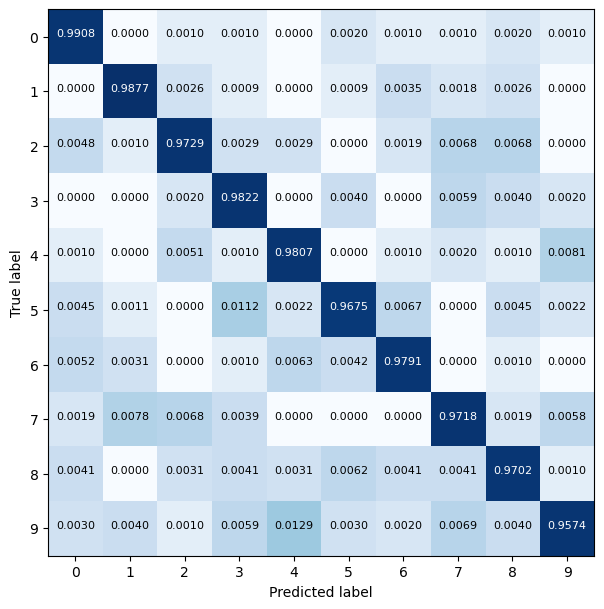

In [57]:
plot_confusion_matrix(cm, range(10), normalize=True)

### Sensitivity to initial conditions

How sensitive is the training process to the initial values of the model?  Let's train and evaluate the model several times, and observe the outcomes.

In [59]:
np.random.seed(1234)
tf.random.set_seed(459845)
names = ('train', 'val', 'test')
inputs = (x_train, x_val, x_test)
outputs = (y_train, y_val, y_test)
losses = dict()
accuracies = dict()
for name in names:
    losses[name] = []
    accuracies[name] = []
for i in range(10):
    print(f'training model {i+ 1:d}')
    mod = Sequential()
    mod.add(Dense(512, activation='relu', input_shape=(784,)))
    mod.add(Dropout(0.2))
    mod.add(Dense(512, activation='relu'))
    mod.add(Dropout(0.2))
    mod.add(Dense(10, activation='softmax'))
    mod.compile(loss='categorical_crossentropy', optimizer=SGD(),
                metrics=['accuracy'])
    _ = mod.fit(x_train, y_train, batch_size=128, epochs=100,
                verbose=0, validation_data=(x_val, y_val))
    for name, input, output in zip(names, inputs, outputs):
        loss, accuracy = mod.evaluate(input, output)
        losses[name].append(loss)
        accuracies[name].append(accuracy)
    mod.save(f'mnist_mpl_{i + 1:02d}.h5')

training model 1
313/313 [==============================] - 1s 4ms/step - loss: 0.0746 - accuracy: 0.9768
training model 2


/home/gjb/mambaforge/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 4ms/step - loss: 0.0771 - accuracy: 0.9762
training model 3
313/313 [==============================] - 1s 4ms/step - loss: 0.0749 - accuracy: 0.9780
training model 4
313/313 [==============================] - 1s 4ms/step - loss: 0.0774 - accuracy: 0.9757
training model 5
313/313 [==============================] - 1s 4ms/step - loss: 0.0753 - accuracy: 0.9757
training model 6
313/313 [==============================] - 1s 4ms/step - loss: 0.0730 - accuracy: 0.9778
training model 7
313/313 [==============================] - 1s 4ms/step - loss: 0.0762 - accuracy: 0.9761
training model 8
313/313 [==============================] - 2s 5ms/step - loss: 0.0736 - accuracy: 0.9767
training model 9
313/313 [==============================] - 1s 4ms/step - loss: 0.0763 - accuracy: 0.9774
training model 10
313/313 [==============================] - 1s 4ms/step - loss: 0.0750 - accuracy: 0.9770


Losses and accuracies are quite reproducible across runs with different initializations of the model.

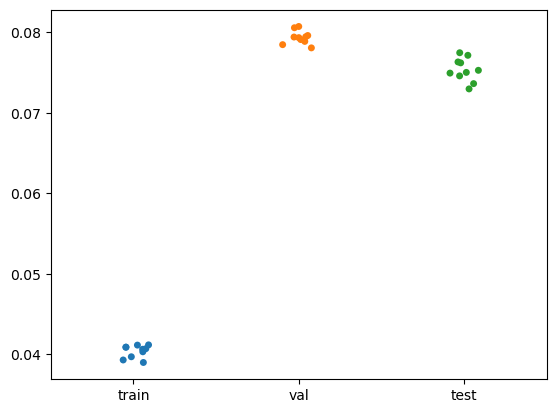

In [60]:
sns.stripplot(data=pd.DataFrame(losses), jitter=0.1);

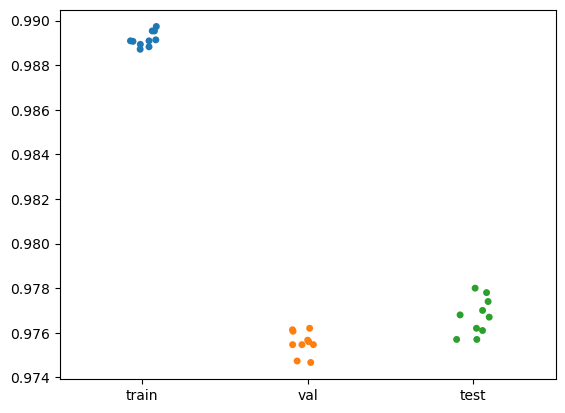

In [61]:
sns.stripplot(data=pd.DataFrame(accuracies), jitter=0.1);